# 01 Unsupervised Segmentation

Perform K-Means clustering on DINOv3 patch features to discover semantic segments without labels.

2025-12-14 16:32:46.784244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765729966.804191    9906 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765729966.810383    9906 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-14 16:32:46.830105: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

[W1214 16:32:53.489775952 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


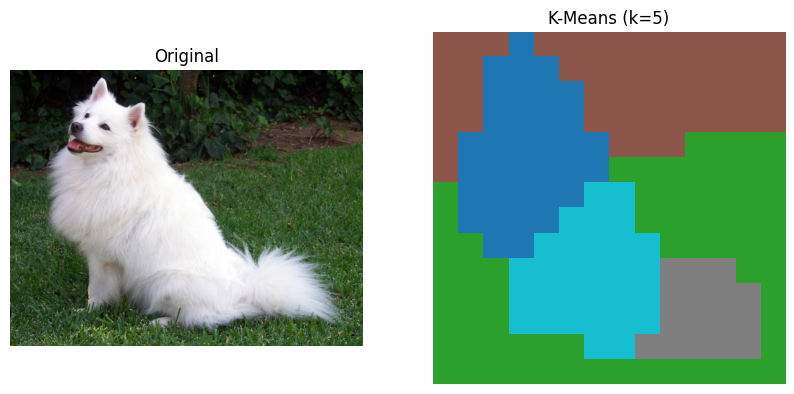

In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor
from sklearn.cluster import KMeans

from dinov3_lab.core.backbone import build_dinov3_hf

# 1. Load Model
model_id = "facebook/dinov3-vitl16-pretrain-lvd1689m"
backbone = build_dinov3_hf(model_id=model_id)
processor = AutoImageProcessor.from_pretrained(model_id)

# 2. Load Image
image_path = "../data/test_images/demo.jpg"
try:
    image = Image.open(image_path).convert("RGB")
except FileNotFoundError:
    print("Demo image not found. Using placeholder.")
    image = Image.new('RGB', (448, 448), color = 'green')

inputs = processor(images=image, return_tensors="pt")

# 3. Extract Features
with torch.no_grad():
    out = backbone(inputs.pixel_values)

patch_tokens = out.patch_tokens[0].float().cpu().numpy()

# 4. K-Means Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(patch_tokens)

h, w = out.patch_hw
seg_map = clusters.reshape(h, w)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(seg_map, cmap="tab10")
plt.title(f"K-Means (k={num_clusters})")
plt.axis("off")
plt.show()